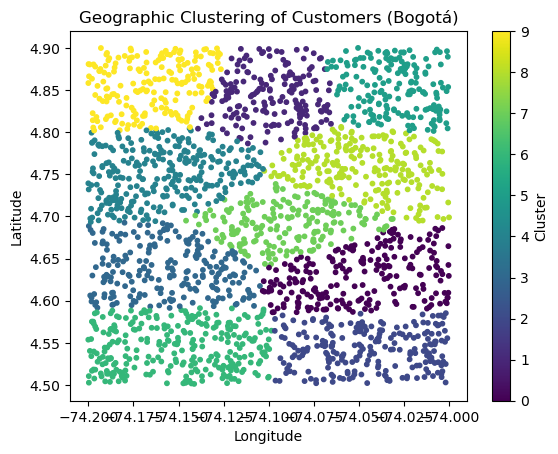

KeyboardInterrupt: 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from geopy.distance import geodesic
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist

# Step 1: Generate Synthetic Customer Data for Bogotá

np.random.seed(42)  # For reproducibility
num_customers = 2199

# Random geographic coordinates around Bogotá
latitudes = np.random.uniform(4.5, 4.9, size=num_customers)
longitudes = np.random.uniform(-74.2, -74.0, size=num_customers)

# Random demand for different product types (dry, chilled, frozen)
dry_demand = np.random.randint(1, 20, size=num_customers)
chilled_demand = np.random.randint(1, 15, size=num_customers)
frozen_demand = np.random.randint(1, 10, size=num_customers)

# Customer DataFrame
customers = pd.DataFrame({
    'Customer_ID': np.arange(1, num_customers + 1),
    'Latitude': latitudes,
    'Longitude': longitudes,
    'Dry_Demand': dry_demand,
    'Chilled_Demand': chilled_demand,
    'Frozen_Demand': frozen_demand
})

# Step 2: Define the Capacitated Clustering Method (k-means with distance-based constraints)

def compute_geographical_distances(customers):
    """Calculate the geographical distance matrix."""
    coordinates = customers[['Latitude', 'Longitude']].values
    dist_matrix = cdist(coordinates, coordinates, metric=lambda x, y: geodesic(x, y).km)
    return dist_matrix

# Apply KMeans (without capacity constraint initially)
kmeans = KMeans(n_clusters=10, random_state=42).fit(customers[['Latitude', 'Longitude']])
customers['Cluster'] = kmeans.labels_

# Visualize the Clusters
plt.scatter(customers['Longitude'], customers['Latitude'], c=customers['Cluster'], cmap='viridis', s=10)
plt.title("Geographic Clustering of Customers (Bogotá)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label='Cluster')
plt.show()

# Step 3: Incorporate Product Demand Similarity in the Distance Measure
alpha = 0.7  # Weight for geographical distance
beta = 0.3   # Weight for product demand similarity

def compute_composite_distance(customers, alpha, beta):
    geo_distances = compute_geographical_distances(customers)
    demand_vectors = customers[['Dry_Demand', 'Chilled_Demand', 'Frozen_Demand']].values
    demand_distances = pairwise_distances(demand_vectors, metric='euclidean')
    
    # Normalize the distance matrices
    geo_distances /= geo_distances.max()
    demand_distances /= demand_distances.max()
    
    # Composite distance
    composite_distance = alpha * geo_distances + beta * demand_distances
    return composite_distance

composite_dist = compute_composite_distance(customers, alpha, beta)

# Step 4: Prepare Clusters for MILP (Save Cluster Information)

def prepare_clusters_for_milp(customers):
    cluster_summary = customers.groupby('Cluster').agg({
        'Dry_Demand': 'sum',
        'Chilled_Demand': 'sum',
        'Frozen_Demand': 'sum',
        'Latitude': 'mean',
        'Longitude': 'mean'
    }).reset_index()

    # Add cluster capacity and time constraints here if needed
    # For now, we just calculate the demand sums
    return cluster_summary

cluster_summary = prepare_clusters_for_milp(customers)
print(cluster_summary)

# Save the result to a CSV or JSON file
#cluster_summary.to_csv('clusters_for_milp.csv', index=False)
